In [97]:
import numpy as np
import pandas as pd
import os

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [98]:
# Data preparation
ROOTDIR = 'datasets'
FILENAME = 'housing.csv'
FILEPATH = os.path.join(ROOTDIR, FILENAME)

df = pd.read_csv(FILEPATH)
df = df.dropna()
df.sample(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
8108,-118.19,33.80,38.0,2010.0,595.0,1535.0,525.0,1.9848,160400.0,NEAR OCEAN
4677,-118.34,34.08,52.0,1421.0,163.0,495.0,167.0,10.5860,500001.0,<1H OCEAN
3805,-118.44,34.21,20.0,5756.0,1477.0,4031.0,1369.0,3.2448,221200.0,<1H OCEAN
12533,-121.50,38.57,45.0,858.0,254.0,510.0,200.0,1.0114,80000.0,INLAND
7612,-118.23,33.89,35.0,1255.0,344.0,1782.0,343.0,2.1949,95100.0,<1H OCEAN
2298,-119.77,36.81,25.0,1565.0,271.0,661.0,275.0,3.4279,84700.0,INLAND
6686,-118.07,34.15,45.0,1095.0,237.0,672.0,234.0,3.4087,209200.0,INLAND
16240,-121.29,37.99,41.0,930.0,191.0,463.0,185.0,3.4141,90600.0,INLAND
8822,-118.35,34.09,35.0,2234.0,689.0,1334.0,662.0,2.5444,236100.0,<1H OCEAN
14328,-117.17,32.71,7.0,2493.0,693.0,951.0,641.0,4.2375,205000.0,NEAR OCEAN


In [99]:
# # Convert ocean_proximity
le = LabelEncoder()
df['ocean_proximity_encoded'] =  le.fit_transform(df.ocean_proximity.values)

In [106]:
# Convert df to numpy array
# y_column = ['median_house_value']
# X_columns = df.columns.difference(y_column + ['ocean_proximity'])
X_columns = df.columns.difference(['ocean_proximity', 'latitude', 'longitude'])

# X = df[X_columns].values
# y = df[y_column].values.reshape(-1)

scaler = MinMaxScaler()
X = df[X_columns].values
X_scaled = scaler.fit_transform(X)

# X.shape, y.shape

### Method 1: IsoTree (RandomForest)

In [107]:
clf = IsolationForest(n_estimators=50, warm_start=True)
clf.fit(X_scaled)

predicted_class = clf.predict(X_scaled)
df['predicted_class'] = predicted_class
df.groupby('predicted_class').size()

predicted_class
-1     4244
 1    16189
dtype: int64

In [102]:
# Simple visualization for sanity check
from sklearn.decomposition import PCA
pca = PCA(3)

df_pca = pd.DataFrame(pca.fit_transform(df[X_columns]))
df_pca.columns = ['pc1', 'pc2', 'pc3']
X_reduced = df_pca.values

df_pca['predicted_class'] = df.predicted_class.astype(np.int32)
df_pca

,pc1,pc2,pc3,predicted_class
0,245730.472036,-2666.830680,88.337902,-1.0
1,151646.355722,4192.064367,-860.524461,-1.0
2,145232.260013,-1841.274951,-148.547899,-1.0
3,134431.809818,-1947.645167,-14.710005,1.0
4,135332.712947,-1623.191797,-160.764941,1.0
...,...,...,...,...
20428,-128766.368591,-871.088238,-270.154161,-1.0
20429,-129768.774693,-1995.022743,-298.704824,1.0
20430,-114564.926034,-282.458140,-358.703997,1.0
20431,-122165.861711,-749.616464,-438.140118,1.0


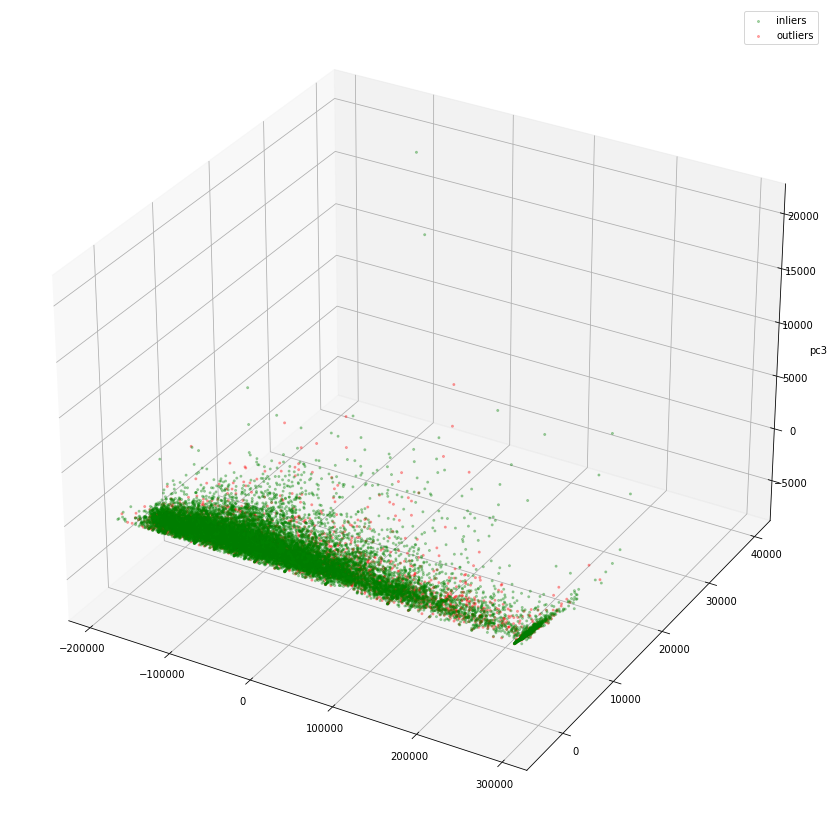

In [108]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("pc3")
fig.set_size_inches(20,15)

df_pca_inlier = df_pca[df_pca.predicted_class.eq(1)]
df_pca_outlier = df_pca[df_pca.predicted_class.eq(-1)]
ax.scatter(df_pca_inlier.pc1.values, 
        df_pca_inlier.pc2.values, 
        zs=df_pca_inlier.pc3.values, 
        s=4, 
        lw=1, 
        label="inliers",
        alpha=0.3, 
        c="green")

ax.scatter(df_pca_outlier.pc1.values, 
        df_pca_outlier.pc2.values, 
        zs=df_pca_outlier.pc3.values, 
        s=4, 
        lw=1, 
        label="outliers", 
        alpha=0.3,
        c="red")

ax.legend()
plt.show()

In [104]:
df[df.predicted_class.eq(1)].sort_values('median_house_value')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_encoded,predicted_class
9188,-117.86,34.24,52.0,803.0,267.0,628.0,225.0,4.1932,14999.0,INLAND,1,1
5887,-118.33,34.15,39.0,493.0,168.0,259.0,138.0,2.3667,17500.0,<1H OCEAN,0,1
3027,-119.45,35.13,34.0,1440.0,309.0,808.0,294.0,2.3013,26600.0,INLAND,1,1
3028,-119.46,35.13,46.0,2745.0,543.0,1423.0,482.0,2.1955,26900.0,INLAND,1,1
3018,-119.45,35.07,45.0,973.0,183.0,500.0,177.0,2.6389,30000.0,INLAND,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5284,-118.47,34.05,25.0,2689.0,719.0,1229.0,663.0,3.5909,500001.0,<1H OCEAN,0,1
5279,-118.47,34.06,45.0,3030.0,433.0,916.0,399.0,9.4664,500001.0,<1H OCEAN,0,1
5278,-118.47,34.06,45.0,1271.0,190.0,419.0,171.0,7.6447,500001.0,<1H OCEAN,0,1
8568,-118.42,33.90,29.0,1929.0,523.0,686.0,455.0,5.5347,500001.0,<1H OCEAN,0,1


In [105]:
df[df.predicted_class.eq(-1)].sort_values('median_house_value')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_encoded,predicted_class
2799,-117.02,36.40,19.0,619.0,239.0,490.0,164.0,2.1000,14999.0,INLAND,1,-1
19802,-123.17,40.31,36.0,98.0,28.0,18.0,8.0,0.5360,14999.0,INLAND,1,-1
2521,-122.74,39.71,16.0,255.0,73.0,85.0,38.0,1.6607,14999.0,INLAND,1,-1
1825,-122.32,37.93,33.0,296.0,73.0,216.0,63.0,2.6750,22500.0,NEAR BAY,3,-1
14326,-117.16,32.71,52.0,845.0,451.0,1230.0,375.0,1.0918,22500.0,NEAR OCEAN,4,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
8760,-118.44,33.81,33.0,3994.0,990.0,1647.0,931.0,5.0106,500001.0,NEAR OCEAN,4,-1
8764,-118.37,33.81,36.0,1283.0,209.0,563.0,209.0,6.9296,500001.0,NEAR OCEAN,4,-1
15303,-117.36,33.17,24.0,2046.0,442.0,812.0,367.0,2.3182,500001.0,NEAR OCEAN,4,-1
8586,-118.39,33.90,7.0,4314.0,725.0,1699.0,718.0,8.2037,500001.0,<1H OCEAN,0,-1
